In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from utils.hfDataset import MHCoPilot_Dataset 
from generation_data_prepro1 import _add_spans2posts, _generate_llama2_inputs, sample_test_adder, generate_category_classifier_train_data, generate_category_classifier_trainset

/home/bhagesh20558/miniconda3/envs/mhcp3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map: 100%|██████████| 476/476 [00:00<00:00, 1250.24 examples/s]


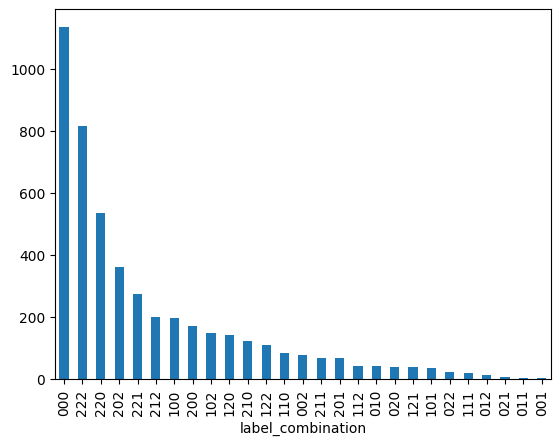

In [3]:
data_path = "../data"
data_task =  "general"
data_ner = False
make_new_split = True

Dataset = MHCoPilot_Dataset(data_path, task = data_task, ner = data_ner, make_new_split = make_new_split)
Dataset.get_data()
Dataset.train_df = Dataset.train_df.map(sample_test_adder)
Dataset.train_df = Dataset.train_df.map(_add_spans2posts)
Dataset.train_df = Dataset.train_df.map(_generate_llama2_inputs)

Dataset.val_df = Dataset.val_df.map(sample_test_adder)
Dataset.val_df = Dataset.val_df.map(_add_spans2posts)
Dataset.val_df = Dataset.val_df.map(_generate_llama2_inputs)

Dataset.test_df = Dataset.test_df.map(sample_test_adder)
Dataset.test_df = Dataset.test_df.map(_add_spans2posts)
Dataset.test_df = Dataset.test_df.map(_generate_llama2_inputs)

In [4]:
Dataset.train_df[0]

{'title': 'Been adicited to opiates (oxy) consistently for 3 years and want stop. Please help.',
 'body': "Hello, I'm a 24 year old college student in Northern CA getting ready to graduate with my BS after next semester and I am addicted to oxycodone. I've never said this out loud before but I believe myself to be a functional opiate addict with no prior drug related addictions or mental health problems. I  was intoduced to painkillers (norcos) in 2013 when I got surgery on my torn ACL and was prescribed a (60 count I believe) bottle which I refilled once. Since then I have been taking opiates on and off for the last 6 years. I've really been taking opiates consistently for the last 2 years though, at this point I've grown dependent to oxycodone (taking on avg. between 2-5, 30mg pills a day) and have tried to stop on my own but within the last few months, but have unable to stop. I'm on this forum today asking for advice on what I should do. Everytime I've tried to stop on my own I get

In [5]:
Dataset.train_df = Dataset.train_df.map(generate_category_classifier_train_data)

Map: 100%|██████████| 3331/3331 [00:02<00:00, 1255.35 examples/s]


In [6]:
cc_train_data = generate_category_classifier_trainset(Dataset.train_df)

In [7]:
cc_train_data = cc_train_data.filter(lambda example: example['question'] != '')

Filter: 100%|██████████| 9993/9993 [00:00<00:00, 42757.24 examples/s]


In [8]:
cc_train_data

Dataset({
    features: ['question', 'labels'],
    num_rows: 3890
})

In [9]:
Dataset.val_df = Dataset.val_df.map(generate_category_classifier_train_data)
cc_val_data = generate_category_classifier_trainset(Dataset.val_df)
cc_val_data = cc_val_data.filter(lambda example: example['question'] != '')
cc_val_data

Filter: 100%|██████████| 2859/2859 [00:00<00:00, 41079.07 examples/s]


Dataset({
    features: ['question', 'labels'],
    num_rows: 1110
})

In [10]:
Dataset.test_df = Dataset.test_df.map(generate_category_classifier_train_data)
cc_test_data = generate_category_classifier_trainset(Dataset.test_df)
cc_test_data = cc_test_data.filter(lambda example: example['question'] != '')
cc_test_data

Map:   0%|          | 0/476 [00:00<?, ? examples/s]

Filter: 100%|██████████| 1428/1428 [00:00<00:00, 37676.71 examples/s]


Dataset({
    features: ['question', 'labels'],
    num_rows: 560
})

In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
def tokenize_function(examples):
    return tokenizer(examples['question'], padding="max_length", truncation=True, max_length=512)

cc_train_data_tokenized = cc_train_data.map(tokenize_function, batched=True)
cc_val_data_tokenized = cc_val_data.map(tokenize_function, batched=True)
cc_test_data_tokenized = cc_test_data.map(tokenize_function, batched=True)

Map: 100%|██████████| 560/560 [00:00<00:00, 1098.38 examples/s]


In [12]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir='./results_cc',       
    num_train_epochs=2,             
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=16,  
    warmup_steps=500,                
    weight_decay=0.01,              
    logging_dir='./logs_cc',           
    logging_steps=10,
    evaluation_strategy="epoch",     
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cc_train_data_tokenized,
    eval_dataset=cc_val_data_tokenized,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

/home/bhagesh20558/miniconda3/envs/mhcp3/lib/python3.8/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karan21258 (karan912). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.005700,0.153314,0.967568
2,0.059200,0.066118,0.987387


TrainOutput(global_step=974, training_loss=0.20546543101820275, metrics={'train_runtime': 341.1788, 'train_samples_per_second': 22.803, 'train_steps_per_second': 2.855, 'total_flos': 2047022389923840.0, 'train_loss': 0.20546543101820275, 'epoch': 2.0})

In [16]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.06611756980419159, 'eval_accuracy': 0.9873873873873874, 'eval_runtime': 13.0782, 'eval_samples_per_second': 84.874, 'eval_steps_per_second': 5.352, 'epoch': 2.0}


In [18]:
predictions = trainer.predict(cc_test_data_tokenized)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

accuracy = accuracy_score(labels, preds)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9839285714285714


In [19]:
model.save_pretrained('./cc_saved_model')
tokenizer.save_pretrained('./cc_saved_model')

('./cc_saved_model/tokenizer_config.json',
 './cc_saved_model/special_tokens_map.json',
 './cc_saved_model/vocab.json',
 './cc_saved_model/merges.txt',
 './cc_saved_model/added_tokens.json')

In [21]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
loaded_model = RobertaForSequenceClassification.from_pretrained('./cc_saved_model')
loaded_tokenizer = RobertaTokenizer.from_pretrained('./cc_saved_model')